In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader,Dataset
from torch import optim
import glob
import random
from PIL import Image

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
# maps image pixels from [0,1] to [-1,1]
Transform=T.Compose([T.Grayscale(),T.Resize(28),T.ToTensor(),T.Normalize((0.5),(0.5))])

train_data_path = 'training_data'
labels = set()
train_image_paths = []
for data_path in glob.glob(train_data_path+'/*'):
    labels.add(data_path.split('/')[1])
    train_image_paths.append(glob.glob(data_path+'/*'))

train_image_paths = [item for sublist in train_image_paths for item in sublist]
random.shuffle(train_image_paths)
idx_to_class = {int(j):j for j in labels}
class_to_idx = {value:key for key,value in idx_to_class.items()}
print(class_to_idx)

{'5': 5, '2': 2, '7': 7, '9': 9, '3': 3, '6': 6, '4': 4, '8': 8, '1': 1, '0': 0}


In [4]:
class printed_number_dataset(Dataset):

    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform
        
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)  
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = Image.fromarray(image)  
        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image)
        
        return image,label

In [5]:
train_dataset = printed_number_dataset(train_image_paths,Transform)

In [6]:
import copy,cv2
def visualize_augmentations(dataset, idx=0, samples=10, cols=5, random_img = False):
    
    dataset = copy.deepcopy(dataset)
    dataset.transform = T.Compose([T.Grayscale(),T.Resize(28)])
    rows = samples // cols
    
        
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))
    for i in range(samples):
        if random_img:
            idx = np.random.randint(1,len(train_image_paths))
        image, lab = dataset[idx]
        ax.ravel()[i].imshow(image,'gray')
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(idx_to_class[lab])
    plt.tight_layout(pad=1)
    plt.show()  

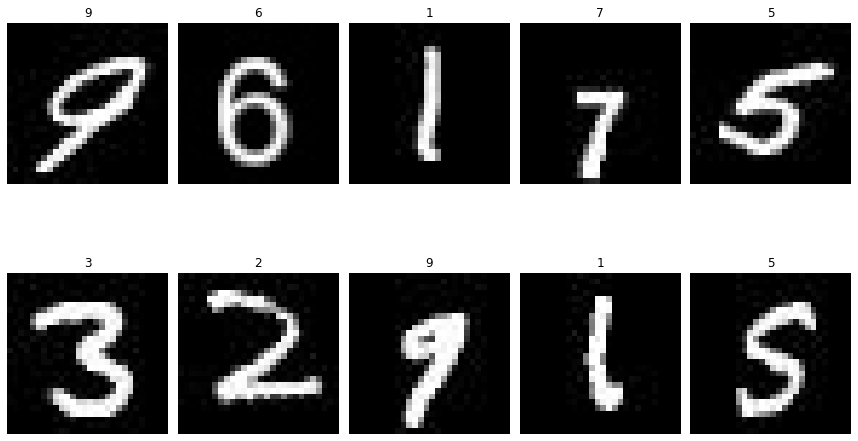

In [7]:
visualize_augmentations(train_dataset,np.random.randint(1,len(train_image_paths)), random_img = True)

In [8]:
train_loader = DataLoader(train_dataset,64,shuffle=True)

In [39]:
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()        
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )        # fully connected layer, output 10 classes
        self.conv3 = nn.Sequential(
            nn.Conv2d(32,48,5,1,2), 
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(48,64,5,1,2), 
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.out = nn.Linear(64, 10)    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)        
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization

In [40]:
cnn = CNN()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(),lr=0.01)

In [41]:
from torch.autograd import Variable
num_epochs = 5
def train(num_epochs, cnn, loader):
    
    cnn.train()
        
    total_step = len(loader)
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loader):
            
            b_x = Variable(images)   
            b_y = Variable(labels)   
            output = cnn(b_x)[0]   

            loss = loss_func(output, b_y)
 
            optimizer.zero_grad()           
            loss.backward()                       
            optimizer.step()                
            
            if(i%100==99):
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                        .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))               
                pass
        
        pass
    
    
    pass

train(num_epochs, cnn, train_loader)

Epoch [1/5], Step [100/646], Loss: 0.5243
Epoch [1/5], Step [200/646], Loss: 0.2353
Epoch [1/5], Step [300/646], Loss: 0.1627
Epoch [1/5], Step [400/646], Loss: 0.1023
Epoch [1/5], Step [500/646], Loss: 0.1575
Epoch [1/5], Step [600/646], Loss: 0.1677
Epoch [2/5], Step [100/646], Loss: 0.2216
Epoch [2/5], Step [200/646], Loss: 0.0665
Epoch [2/5], Step [300/646], Loss: 0.1270
Epoch [2/5], Step [400/646], Loss: 0.2180
Epoch [2/5], Step [500/646], Loss: 0.1363
Epoch [2/5], Step [600/646], Loss: 0.2026
Epoch [3/5], Step [100/646], Loss: 0.2725
Epoch [3/5], Step [200/646], Loss: 0.1143
Epoch [3/5], Step [300/646], Loss: 0.3985
Epoch [3/5], Step [400/646], Loss: 0.0469
Epoch [3/5], Step [500/646], Loss: 0.1093
Epoch [3/5], Step [600/646], Loss: 0.0330
Epoch [4/5], Step [100/646], Loss: 0.0269
Epoch [4/5], Step [200/646], Loss: 0.0365
Epoch [4/5], Step [300/646], Loss: 0.3145
Epoch [4/5], Step [400/646], Loss: 0.0741
Epoch [4/5], Step [500/646], Loss: 0.2287
Epoch [4/5], Step [600/646], Loss:

In [42]:
torch.save(cnn.state_dict(),'model.pth')